In [1]:
%load_ext autoreload
%autoreload 2
%env PYTHONWARNINGS ignore
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@dev

In [2]:
from cudams.utils import argbatch, mkdir, get_ref_spectra_from_df, get_spectra_batches
from cudams.similarity.kernels import compile_cuda_cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

assert cuda.is_available()

In [3]:
## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 512

# How many peaks to retain from given spectra.
# Some spectra are extremely large
# MAX NUMBER OF PEAKS 
MAX_PEAKS = 1024

In [4]:
from cudams.utils import download

fpath = download('GNPS-LIBRARY.mgf')

In [5]:
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf

def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
    spectrum = normalize_intensities(spectrum)
    return spectrum

spectrums = Parallel(-2)(delayed(parse_spectrum)(spec) 
                         for spec in tqdm(load_from_mgf(fpath)))
spectrums = [spe for spe in spectrums if spe is not None]

0it [00:00, ?it/s]

1543it [00:03, 1007.37it/s]

2024-02-26 22:59:19,703:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-02-26 22:59:19,791:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-02-26 22:59:19,874:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


3285it [00:06, 714.34it/s] 

2024-02-26 22:59:22,333:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,345:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,358:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,385:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,393:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,396:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,402:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,505:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26 22:59:22,508:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-02-26

3448it [00:06, 699.29it/s]

2024-02-26 22:59:22,548:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Al-2H]
2024-02-26 22:59:22,602:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[2M+H]+']


3996it [00:07, 845.86it/s]

2024-02-26 22:59:23,339:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]


4422it [00:07, 929.80it/s]

2024-02-26 22:59:23,730:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]
2024-02-26 22:59:23,774:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H+]
2024-02-26 22:59:23,781:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]
2024-02-26 22:59:23,814:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H+]


4758it [00:08, 880.11it/s]

2024-02-26 22:59:24,283:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+NH4;]
2024-02-26 22:59:24,431:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H-CO]
2024-02-26 22:59:24,439:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-CO+Hputative]
2024-02-26 22:59:24,461:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-CO+H]


5039it [00:08, 832.32it/s]

2024-02-26 22:59:24,581:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2
2024-02-26 22:59:24,605:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-02-26 22:59:24,615:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-02-26 22:59:24,626:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-02-26 22:59:24,634:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-02-26 22:59:24,648:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-02-26 22:59:24,654:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]


5215it [00:08, 764.05it/s]

2024-02-26 22:59:24,797:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-3H+Fe+Na]
2024-02-26 22:59:24,802:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-3H+Fe+Na]


6275it [00:10, 853.74it/s]

2024-02-26 22:59:26,175:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-02-26 22:59:26,178:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


7261it [00:11, 938.35it/s]

2024-02-26 22:59:27,477:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Al]+']


11794it [00:15, 1128.00it/s]

2024-02-26 22:59:31,701:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Na]+']
2024-02-26 22:59:31,707:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Na]+']
2024-02-26 22:59:31,749:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+2H+]
2024-02-26 22:59:31,819:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-02-26 22:59:31,836:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


13115it [00:17, 829.51it/s] 

2024-02-26 22:59:33,185:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


14244it [00:19, 739.82it/s]


In [6]:
references = spectrums[:512]
queries = spectrums[:512]

In [7]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from cudams.similarity import CudaCosineGreedy
from joblib import Parallel, delayed

scores = calculate_scores(references=references,
                          queries=queries,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True).to_array()
print(f"Size of matrix of computed similarities: {scores.shape}")

Size of matrix of computed similarities: (512, 512)


In [8]:
match_limits = np.linspace(64, 2048, 8)
scores_cu = []
for match_limit in tqdm(match_limits):
    match_limit = int(match_limit)
    score = calculate_scores(
        references=references,
        queries=queries,
        similarity_function=CudaCosineGreedy(match_limit=match_limit, batch_size=BATCH_SIZE)
    ).to_array()
    scores_cu.append(score)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


In [12]:
x = []
y = []

score = scores['CosineGreedy_score']
matches = scores['CosineGreedy_matches']

R, Q = BATCH_SIZE, BATCH_SIZE
for match_limit, score_cu_ in zip(match_limits, scores_cu):
    
    score_cu = score_cu_['CudaCosineGreedy_score']
    matches_cu = score_cu_['CudaCosineGreedy_matches']
    overflow_cu = score_cu_['CudaCosineGreedy_overflow']
    y_row = []
    print('@ MATCH_LIMIT', match_limit)

    score_eq = np.isclose(score, score_cu)
    score_corr = score_eq.mean()
    print("mean(score_gpu == score_cpu):", score_corr)
    y_row.append(score_corr)
    
    matches_eq = np.isclose(matches, matches_cu)
    matches_corr = matches_eq.mean()
    print("mean(num_match_gpu == num_match_cpu):", matches_corr)
    y_row.append(matches_corr)

    overflow_mean = overflow_cu.mean()
    y_row.append(1 - overflow_mean)
    print("1 - mean(overflow)", 1 - overflow_mean)
    
    y.append(y_row)
    x.append(match_limit)

@ MATCH_LIMIT 64.0
mean(score_gpu == score_cpu): 0.9492225646972656
mean(num_match_gpu == num_match_cpu): 0.9491081237792969
1 - mean(overflow) 0.9488983154296875
@ MATCH_LIMIT 347.42857142857144
mean(score_gpu == score_cpu): 0.9990005493164062
mean(num_match_gpu == num_match_cpu): 0.9989852905273438
1 - mean(overflow) 0.9989852905273438
@ MATCH_LIMIT 630.8571428571429
mean(score_gpu == score_cpu): 0.9999008178710938
mean(num_match_gpu == num_match_cpu): 0.9999008178710938
1 - mean(overflow) 0.9999008178710938
@ MATCH_LIMIT 914.2857142857143
mean(score_gpu == score_cpu): 0.9999961853027344
mean(num_match_gpu == num_match_cpu): 0.9999961853027344
1 - mean(overflow) 0.9999961853027344
@ MATCH_LIMIT 1197.7142857142858
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == num_match_cpu): 1.0
1 - mean(overflow) 1.0
@ MATCH_LIMIT 1481.1428571428573
mean(score_gpu == score_cpu): 1.0
mean(num_match_gpu == num_match_cpu): 1.0
1 - mean(overflow) 1.0
@ MATCH_LIMIT 1764.5714285714287
mean(score_

Text(0.5, 0, 'MATCH_LIMIT')

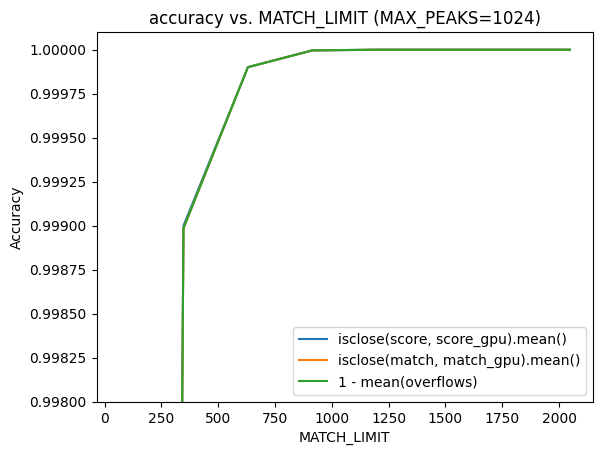

In [13]:
plt.plot(x,np.array(y))
plt.ylim([.998,1.0001])

plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['isclose(score, score_gpu).mean()',
            'isclose(match, match_gpu).mean()',
            "1 - mean(overflows)"])
plt.ylabel("Accuracy")
plt.xlabel("MATCH_LIMIT")

Text(0.5, 0, 'MATCH_LIMIT')

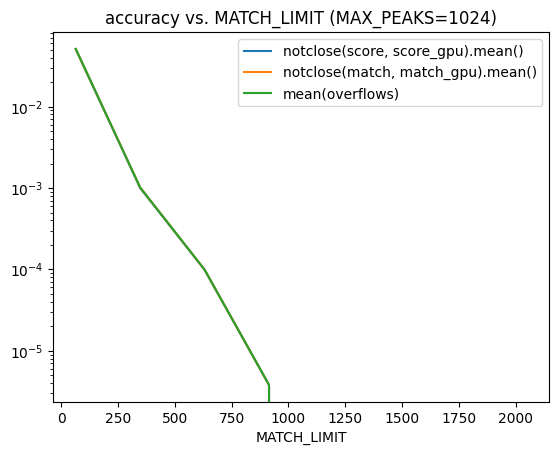

In [14]:
plt.semilogy(x, 1 - np.array(y))
plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['notclose(score, score_gpu).mean()',
            'notclose(match, match_gpu).mean()',
            "mean(overflows)"])
plt.xlabel("MATCH_LIMIT")